<a href="https://colab.research.google.com/github/guilhermeguy/final-report-puc/blob/main/xray_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 15.8 MB/s 


In [3]:
import pandas as pd 
import numpy as np
import seaborn as sns
import pydicom
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
base = '/content/drive/MyDrive/#PUC-Pós/TCC/base'

In [5]:
train_df = pd.read_csv(base + '/train.csv')
test_df = pd.read_csv(base + '/sample_submission.csv')

### Exploração dos dados e Análise dos Dados

Os rótulos estão codificados como número inteiro.

In [6]:
train_df['Target'].value_counts()

3            724
14           120
11           102
0             80
2             77
6             70
15            67
21            63
13 20         45
9 21          42
1             41
16            40
13            39
9             31
17            23
5             23
12            19
10            19
7             15
20            15
8             12
0 3           11
18            10
4              9
19             7
1 6            7
1 11 12        5
10 19          4
2 13 20        3
5 8            2
10 11 19       2
15 19          2
2 20           1
3 7            1
1 12           1
7 9            1
3 6            1
0 15           1
3 15           1
11 12          1
8 16           1
Name: Target, dtype: int64

In [7]:
partes_corpo = {
    0: 'Abdômen',
    1: 'Tornozelo',
    2: 'Espinha cervical', 
    3: 'Tórax',
    4: 'Clavícula',
    5: 'Cotovelo',
    6: 'Pé',
    7: 'Dedo',
    8: 'Ante-braço',
    9: 'Mão',
    10: 'Quadril',
    11: 'Joelho',
    12: 'Panturrilha',
    13: 'Espinha Lombar',
    14: 'Outros',
    15: 'Pélvis',
    16: 'Ombro',
    17: 'Sinus', 
    18: 'Crânio',
    19: 'Coxa',
    20: 'Espinha Toráxica',
    21: 'Punho'
    }

In [8]:
def criar_rotulos(target):
  rotulo = []
  target = target.strip()
  target = target.split(' ')
  target = [int(n) for n in target]
  for num in target:
    rotulo.append(partes_corpo[num])
  rotulo = ' e '.join(rotulo)
  return rotulo




In [9]:
train_df['rotulo'] = train_df['Target'].apply(criar_rotulos)

In [10]:
cont_rotulos = train_df.groupby(by='rotulo')['rotulo'].count()
cont_rotulos = cont_rotulos.reset_index(name='cont')
cont_rotulos = cont_rotulos.sort_values(by='cont', ascending=False)
cont_rotulos.reset_index(inplace=True, drop=True)
cont_rotulos

,rotulo,cont
0,Tórax,724
1,Outros,120
2,Joelho,102
3,Abdômen,80
4,Espinha cervical,77
5,Pé,70
6,Pélvis,67
7,Punho,63
8,Espinha Lombar e Espinha Toráxica,45
9,Mão e Punho,42


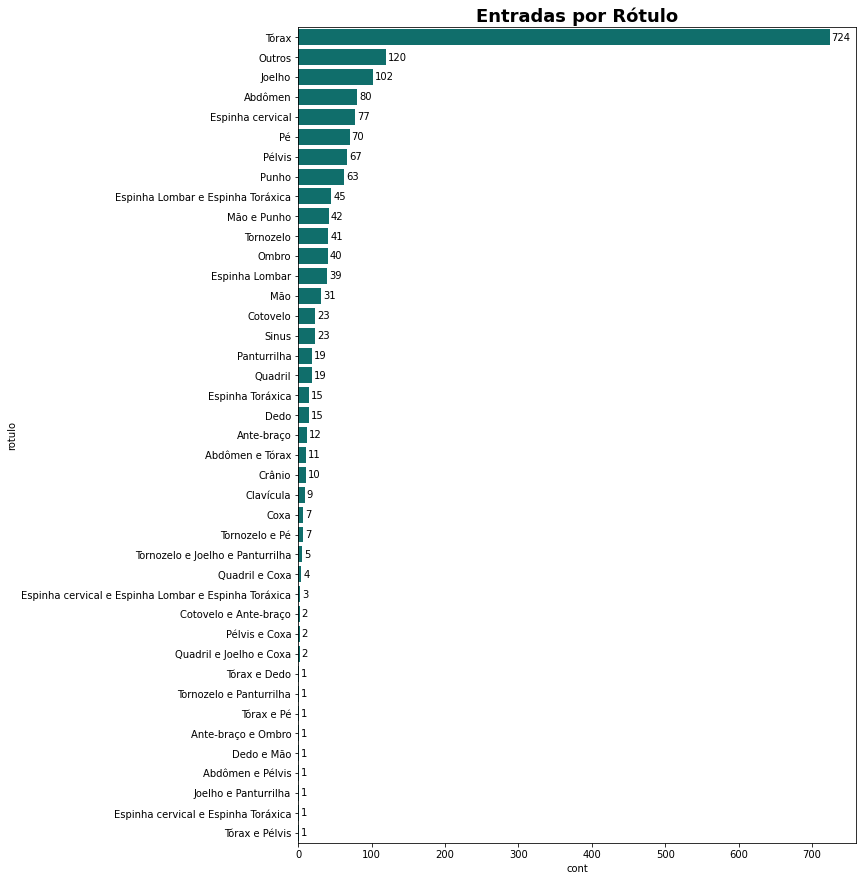

In [17]:
plt.figure(figsize=(10,15))
ys = cont_rotulos['rotulo']
xs = cont_rotulos['cont']
sns.barplot(x=xs, y=ys, color='#007e7a')
# plt.xticks(rotation=80)
plt.title('Entradas por Rótulo', fontdict={'fontsize': 18, 'fontweight': 'bold'})
yi = 0
for x, y in zip(xs, ys):
  plt.annotate(x, (x, yi), textcoords='offset points', xytext=(2, 0), va='center')
  yi +=1

Function created by Felipe Kitamura to list tags from DICOM files

In [12]:
def dcmtag2table(folder, list_of_tags):
    """
    # Create a Pandas DataFrame with the <list_of_tags> DICOM tags
    # from the DICOM files in <folder>
    # Parameters:
    #    folder (str): folder to be recursively walked looking for DICOM files.
    #    list_of_tags (list of strings): list of DICOM tags with no whitespaces.
    # Returns:
    #    df (DataFrame): table of DICOM tags from the files in folder.
    """
    list_of_tags = list_of_tags.copy()
    items = []
    table = []
    filelist = []
    print("Listing all files...")
    start = time.time()
    for root, dirs, files in os.walk(folder, topdown=False):
        for name in files:
            filelist.append(os.path.join(root, name))
    print("Time: " + str(time.time() - start))
    print("Reading files...")
    time.sleep(2)
    for _f in tqdm(filelist):
        try:
            ds = pydicom.dcmread(_f, stop_before_pixels=True)
            items = []
            items.append(_f)

            for _tag in list_of_tags:
                if _tag in ds:
                    items.append(ds.data_element(_tag).value)
                else:
                    items.append("Not found")

            table.append((items))
        except:
            print("Skipping non-DICOM: " + _f)

            
    list_of_tags.insert(0, "Filename")
    test = list(map(list, zip(*table)))
    dictone = {}

    for i, _tag in enumerate (list_of_tags):
        dictone[_tag] = test[i]

    df = pd.DataFrame(dictone)
    time.sleep(2)
    print("Finished.")
    return df